### Notebook Overview
- The main goal of this notebook is to perform exploratory data analysis and to explore machine learning models.
- For each type of model I'll explore them with all the features and with the feature selection (with and without outliers)

#### Variables Description
- **id** - Unique ID for each home sold
- **date** - Date of the home sale
- **price** - Price of each home sold
- **bedrooms** - Number of bedrooms
- **bathrooms** - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- **sqft_living** - Square footage of the apartments interior living space
- **sqft_lot** - Square footage of the land space
- **floors** - Number of floors
- **waterfront** - A dummy variable for whether the apartment was overlooking the waterfront or not
- **view** - An index from 0 to 4 of how good the view of the property was: 0 = No view, 1 = Fair 2 = Average, 3 = Good, 4 = Excellent
- **condition** - An index from 1 to 5 on the condition of the apartment: 1 = Poor- Worn out, 2 = Fair- Badly worn, 3 = Average, 4 = Good, 5= Very Good
- **grade** - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- **sqft_above** - The square footage of the interior housing space that is above ground level
- **sqft_basement** - The square footage of the interior housing space that is below ground level
- **yr_built** - The year the house was initially built
- **yr_renovated** - The year of the house’s last renovation
- **zipcode** - What zipcode area the house is in
- **lat** - Lattitude
- **long** - Longitude
- **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
- **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [80]:
#Importing all the variables I'm using
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [81]:
#Reading the data
data = pd.read_csv('archive/kc_house_data.csv')
# Creating baseline data to have data without feature selection for testing
baseline_data = data

In [82]:
data.shape

(21613, 21)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

The date is in a dtype object. I'll transform it into a date type and separate the the date in years, months and days.

In [84]:

data['date']=pd.to_datetime(data['date'])
#divide the date to see the influence that the year, month or day have on sales
data['year_sale'] = data['date'].dt.year
data['month_sale'] = data['date'].dt.month
data['day_sale'] = data['date'].dt.day
#Since the interval of the date is just one year, I'll remove that variable.
data = data.drop(['id','date','year_sale'],axis=1)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sale,day_sale
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,910,1965,0,98136,47.5208,-122.393,1360,5000,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2,18


In [85]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sale,day_sale
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,...,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,6.574423,15.688197
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,...,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,3.115308,8.635063
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,4.000000,8.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,6.000000,16.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,9.000000,23.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,12.000000,31.000000


- From this first insights its possible to analyse that in our target variable the mean is 540 008 and the median is 450 000. Since the maximum is 7 700 000 and the minimum is 75 000, this may indicate that there are outliers in the data. Some higher houses may be increasing the mean of the price.
- As is known, an important variable defining the house's price's is the number of bedrooms, in relation with the previous point, we see that the mean of the bedrooms is close to 3 and the maximum value is 33. This correborate's with the previous point. There are outliers that are increasins the general mean of the house's prices.

In [86]:
#Counting the number missing values in the data
data.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
month_sale       0
day_sale         0
dtype: int64

In [87]:
#checking for duplicates
data.duplicated().sum()

0

### Data Visualization

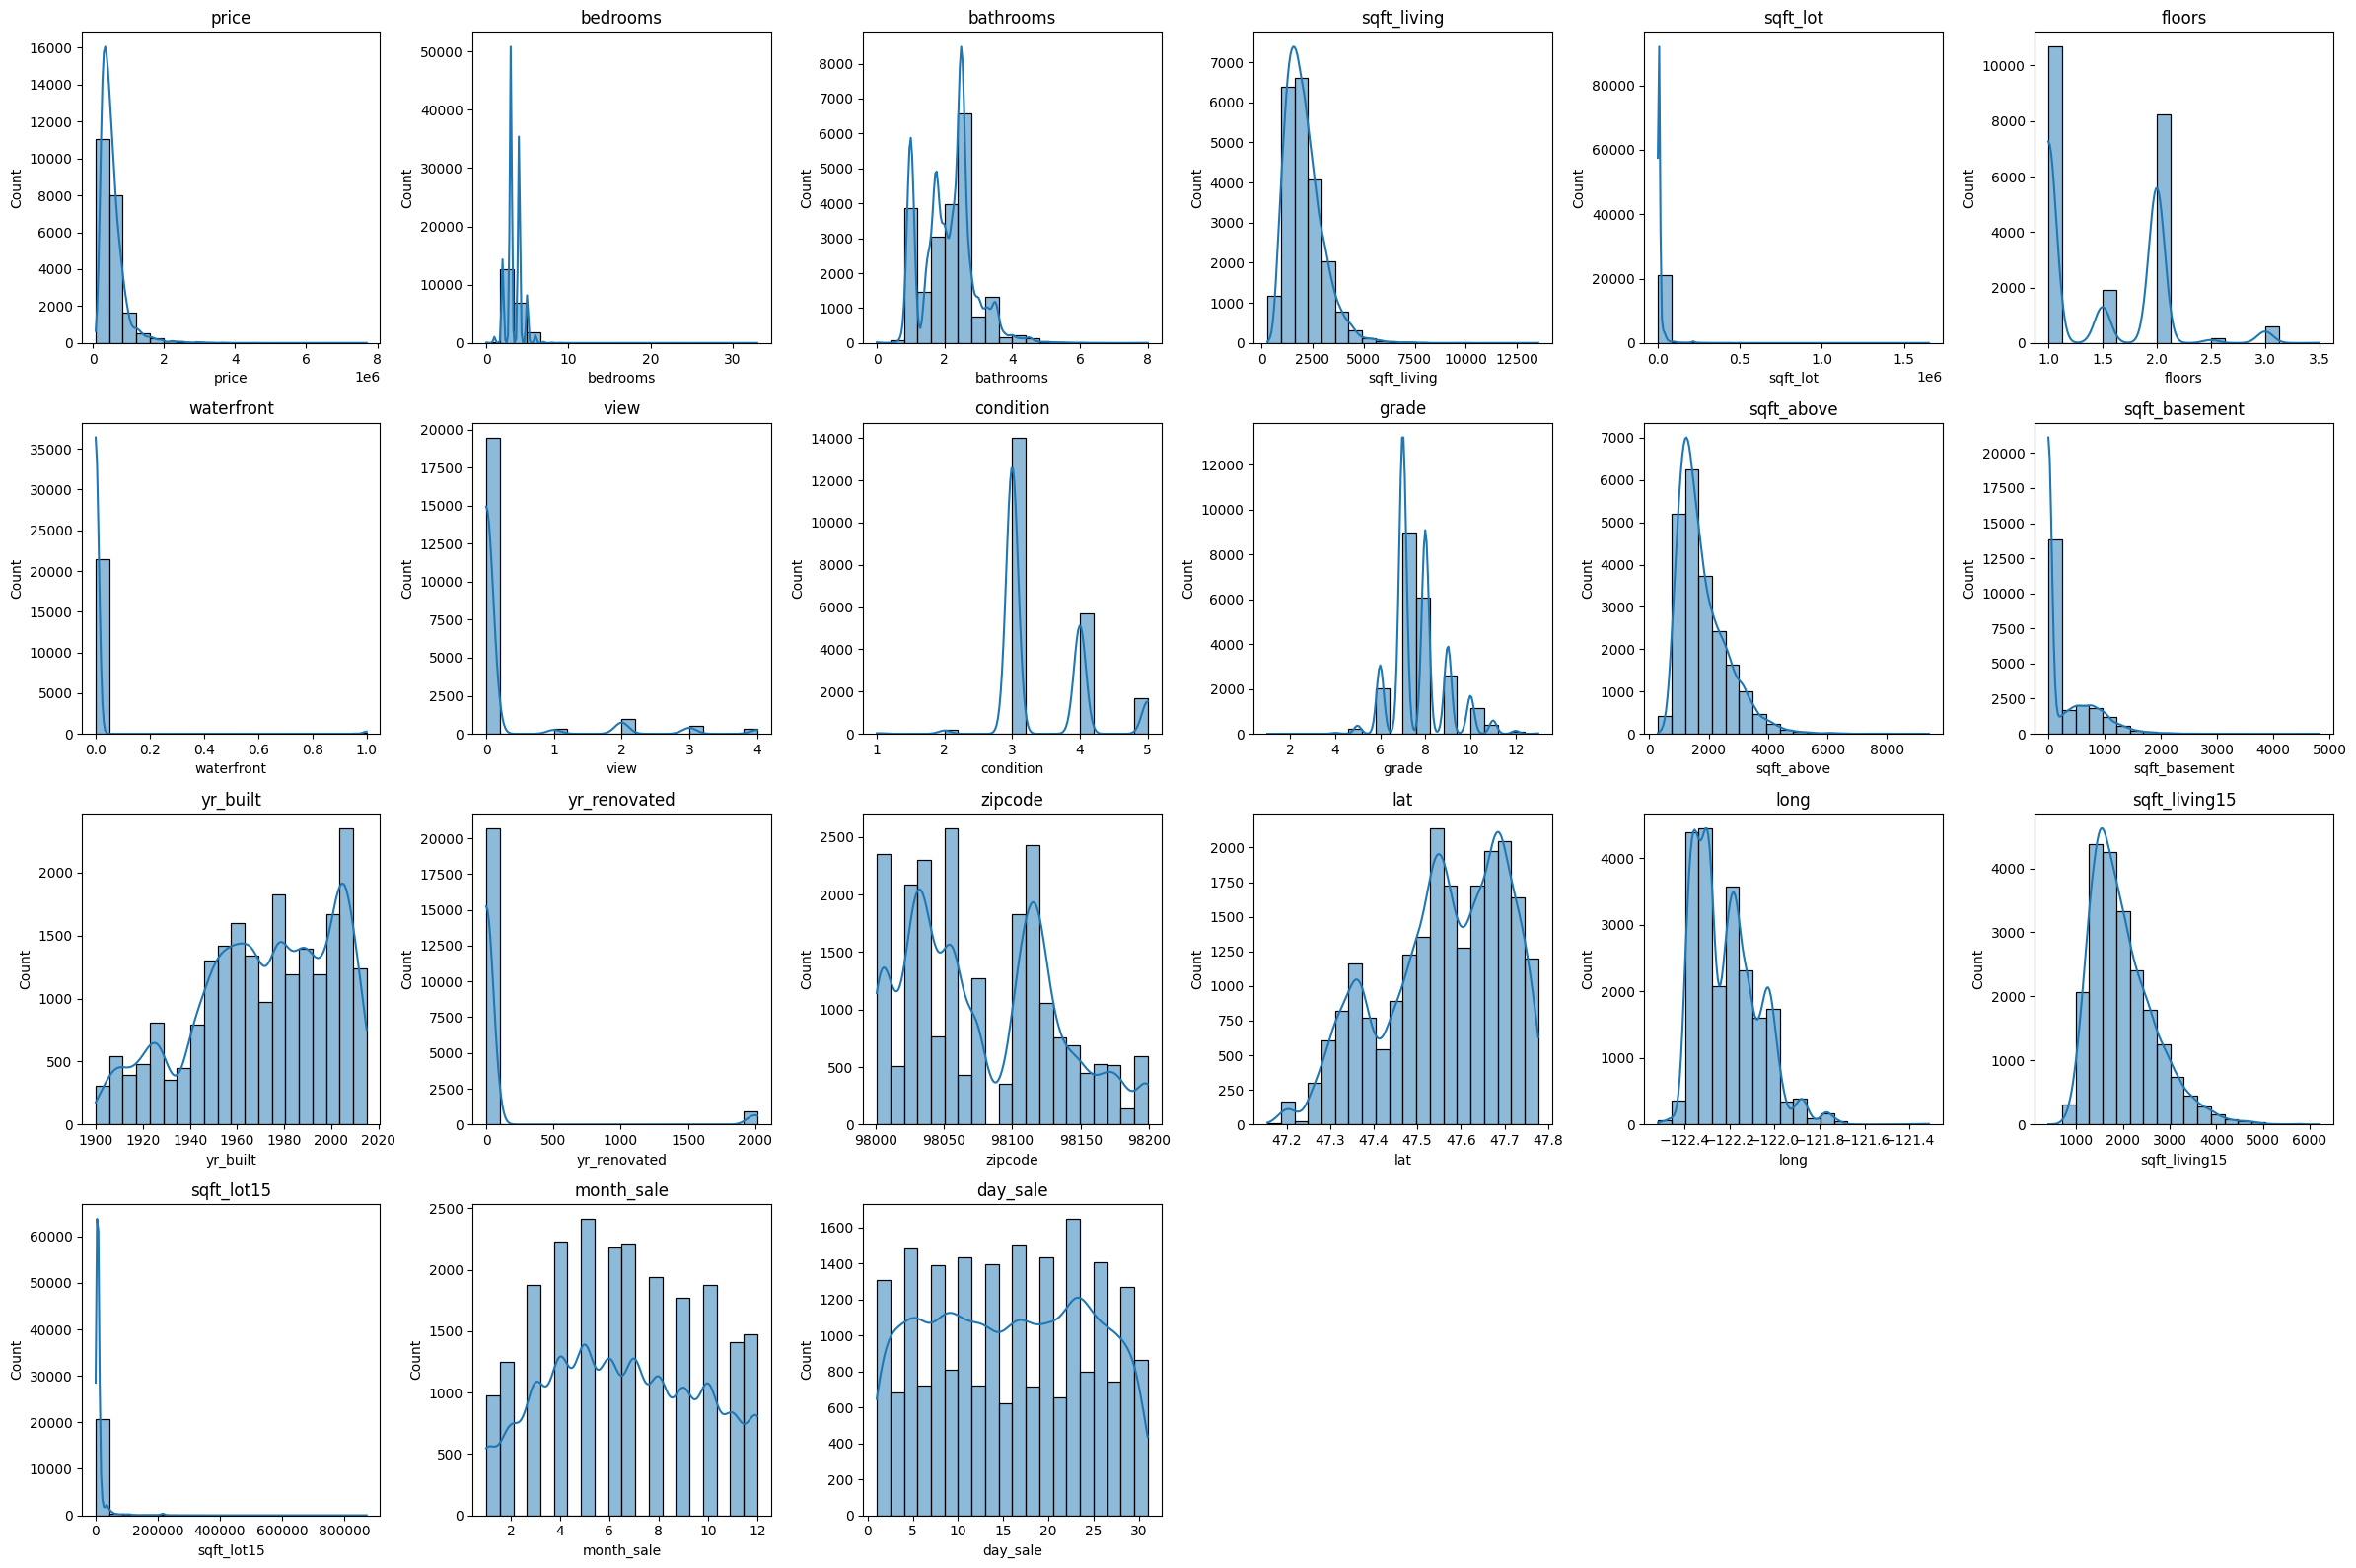

In [88]:
#Plotting the histogram of each variable
plt.figure(figsize=(24, 16))
for feature in data.columns.to_list():
    plt.subplot(4, 6, data.columns.to_list().index(feature) + 1)
    sns.histplot(data=data[feature], bins=20, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

- From the histograms of the 'yr_renovated', 'view' and 'waterfront' its possible to see that most of the values are 0.

In [89]:
# Cicle to print the features that have most of the values 0 (>90%)
for feature in data.columns.to_list():
    s = (data[feature] ==0).sum()
    n = len(data[feature])
    per = (s/n)*100
    if per>90:
        print("Percentage of zeros in " + feature)
        print(str(round(per, 2))+'%')

Percentage of zeros in waterfront
99.25%
Percentage of zeros in view
90.17%
Percentage of zeros in yr_renovated
95.77%


- Although there are 3 variables >90% I'll just remove 'waterfront' since is the only one which the values are above 99%. 
- In the next steps a further analysis must be done to check the others two features

In [90]:
data_cl = data.drop(['waterfront'],axis=1)

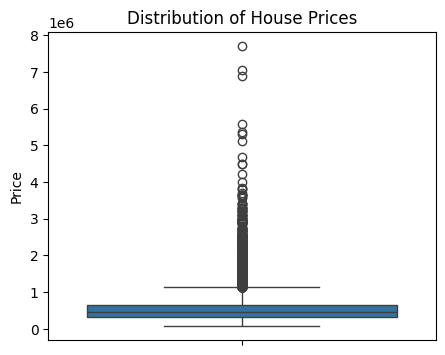

In [91]:
# Understanding better the Price variable
plt.figure(figsize=(5, 4))
sns.boxplot(y=data['price'])
plt.title('Distribution of House Prices')
plt.ylabel('Price')
plt.show()

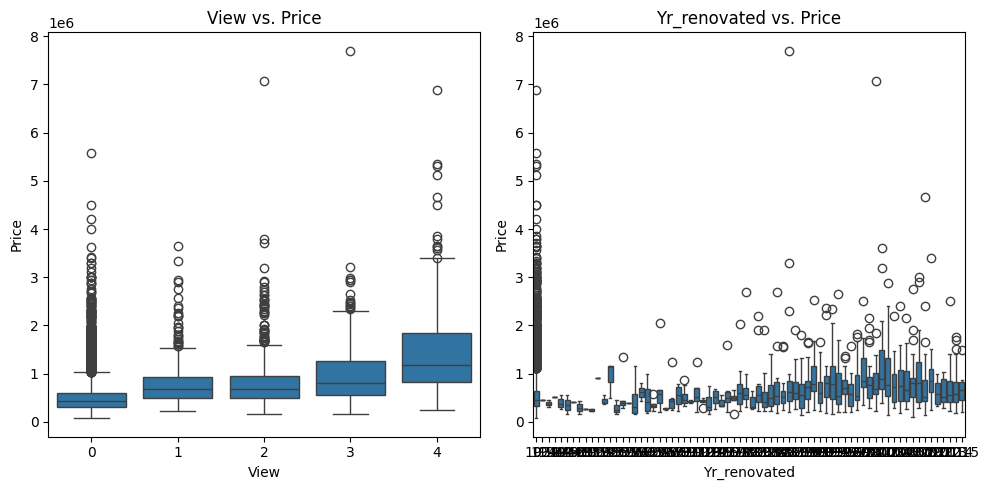

In [92]:
#analysing the relation that the two features with high zero values have with the price
features_of_interest = ['view','yr_renovated']

plt.figure(figsize=(10, 5))

for i, feature in enumerate(features_of_interest, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=feature, y='price', data=data)
    plt.title(f'{feature.capitalize()} vs. Price')
    plt.xlabel(f'{feature.capitalize()}')
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

- Although most of the samples are 0. There are a lot of information that can be important in these two variables

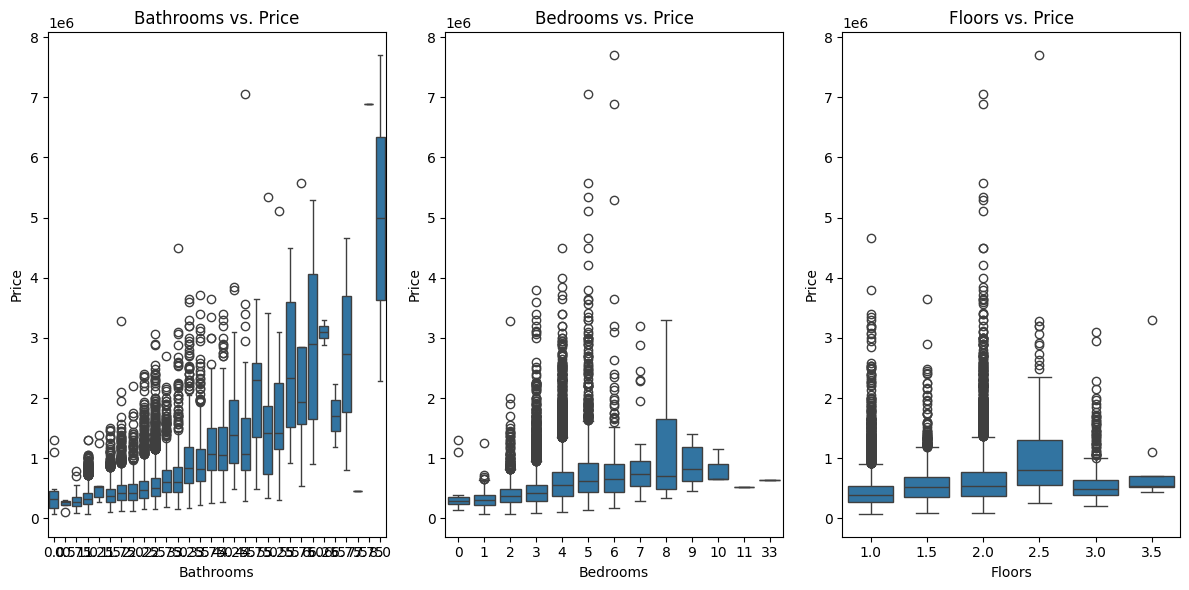

In [93]:
# Box plots for the features 'bathrooms', 'bedrooms', and 'floors' against the target variable
features_of_interest = ['bathrooms', 'bedrooms', 'floors']

plt.figure(figsize=(12, 6))

for i, feature in enumerate(features_of_interest, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=feature, y='price', data=data)
    plt.title(f'{feature.capitalize()} vs. Price')
    plt.xlabel(f'{feature.capitalize()}')
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

- The number of bathrooms seems to have more impact then the the number of bedrooms, which is unexpected.
- The number of floors seems to have less impact on the price then the others

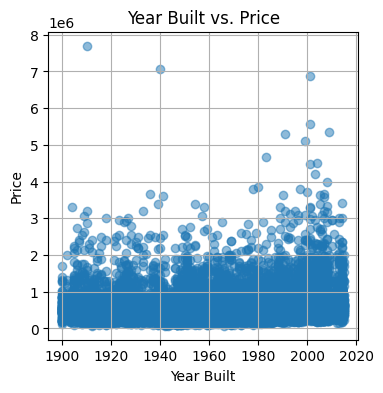

In [94]:
#Checking for relation between year built and the price
plt.figure(figsize=(4, 4))
plt.scatter(data['yr_built'], data['price'], alpha=0.5)
plt.title('Year Built vs. Price')
plt.xlabel('Year Built')
plt.ylabel('Price')
plt.grid(True)
plt.show()

- Generally the scatter-plot illustrates that there's slightly more houses beeing sold at higher values as the years increase.

### Correlation Matrix

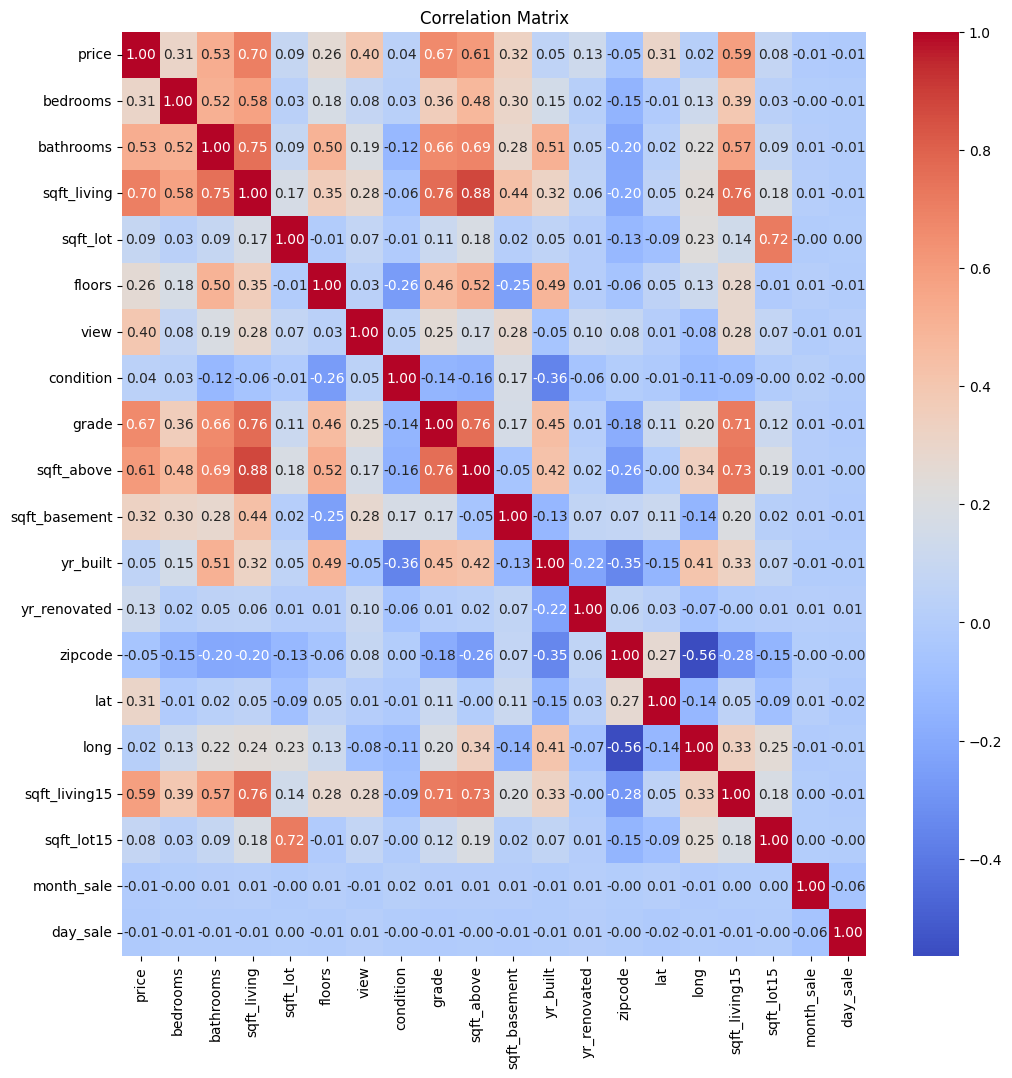

In [95]:
#Creating the correlation matrix for a better analyse of the correlation between the variables.
corr_matrix = data_cl.corr()

#Code to visualize the corr_matrix
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

- The features with low correlation with the target variable may be removed. 
- I'll consider those who have a relationship with the price bellow 0.06.
- The month and day sale will be mantained since they were created and there might be minor trends that influence the price.
- The long is a location variable so its normal that in numbers the location have less impact. But its clear that the latitude have more impact then the longitude.
- The condition, from a house context seems important.
- I will remove the zipcode.
- Features with high correlation with each other may also be removed to avoid multicolinarity.
- Sqft_living and the sqft_above have a really high correlation. I'll remove the sqft_above since has a lower correlation with the target.

In [96]:
data_cl.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sale,day_sale
0,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,9
2,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,18


In [97]:
data_cl = data_cl.drop(['zipcode','sqft_above'],axis=1)

In [98]:
data_cl.columns.to_list()

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view',
 'condition',
 'grade',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'month_sale',
 'day_sale']

### Normalizing the features

- The categorical features that are represented with numbers (ex: 'condition') can also be scaled since there is an inherent ordinal relationship

In [99]:
scaler = MinMaxScaler()
features_scale=['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view',
 'condition',
 'grade',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'month_sale',
 'day_sale']

data_cl[features_scale] = scaler.fit_transform(data_cl[features_scale])

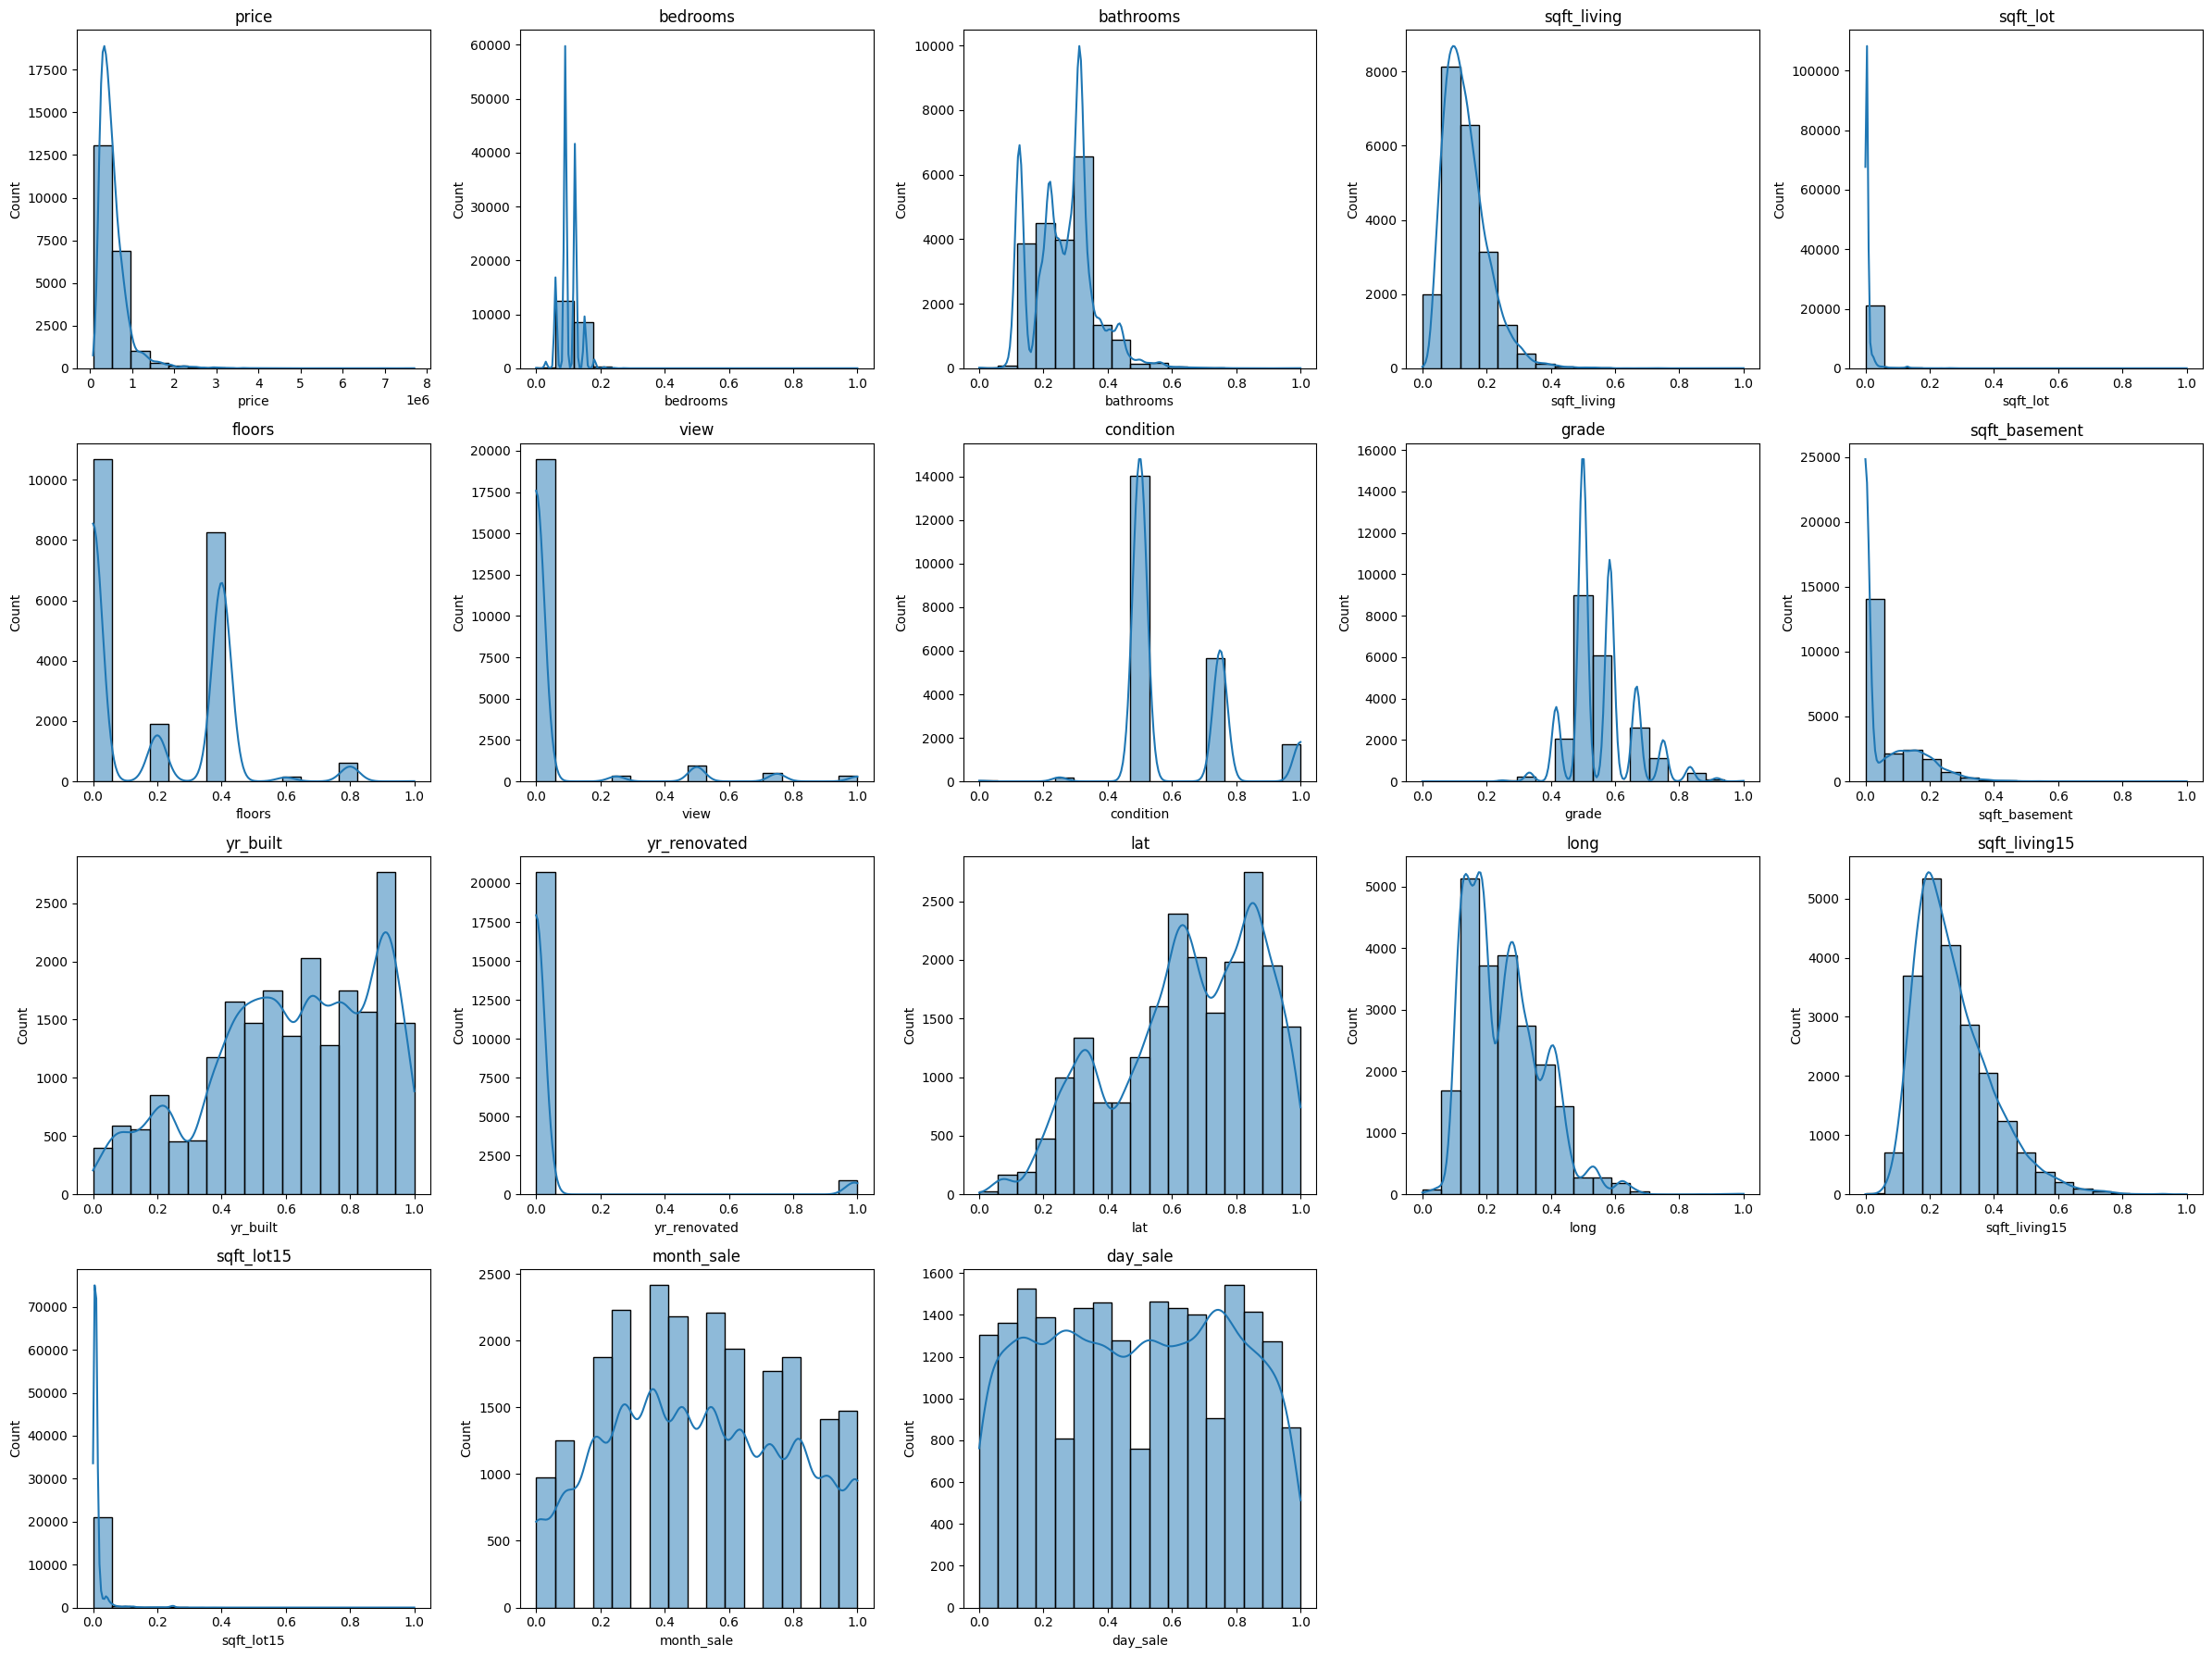

In [100]:
#Plot to check the normalization
plt.figure(figsize=(24, 18))
for feature in data_cl.columns.to_list():
    plt.subplot(4, 5, data_cl.columns.to_list().index(feature) + 1)
    sns.histplot(data=data_cl[feature], bins=17, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

#### Splitting data
 -   **Data Split**: I'll split the data into training and test sets before handling outliers. This ensures the integrity of the test set, preserving its real-world representation.
 -   **Outlier Treatment** in Test Set: While it's acceptable to perform outlier handling in the test set, I've chosen not to do so to maintain its original characteristics. This decision acknowledges that the model's performance might be affected by potential outliers present in the test set.

In [101]:
#For the feature selections tests
X = data_cl.drop('price', axis=1) 
y = data_cl['price']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#For the baseline test
X_baseline = baseline_data.drop(['price', 'date'], axis=1)
y_baseline = baseline_data['price']

X_train_baseline,X_test_baseline,y_train_baseline,y_test_baseline = train_test_split(X_baseline,y_baseline, test_size=0.2, random_state=42)

### Outliers
- **Z-score**: 

In [102]:
z_scores = stats.zscore(y_train)

# We want to eliminate sample that are 3 standard deviations from the mean.
threshold = 3

# Boolean mask for outliers in the target variable
outlier_mask = (abs(z_scores) > threshold)

# Filtering the training set to keep observations without outliers
X_train_no_outliers = X_train[~outlier_mask]
y_train_no_outliers = y_train[~outlier_mask]

# Filtering to keep only observations identified as outliers in the training set
X_train_outliers = X_train[outlier_mask]
y_train_outliers = y_train[outlier_mask]


In [103]:
print('There were ' + str(X_train.shape[0]-X_train_no_outliers.shape[0]) + ' outliers removed')

There were 321 outliers removed


### Models Building
I'll test 3 ML models: 
- Linear Regression
- Support Vector Machine
- XGBoost

In [104]:
#function for calculating rmse
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [105]:
#Creating a data frame to store all the metrics
metrics = pd.DataFrame(columns=['Model', 'RMSE', 'R-squared'])

### Linear regression 

In [106]:

# Initialize the Linear Regression model
lr1 = LinearRegression()
lr2 = LinearRegression()
lr3 = LinearRegression()
# Train the model
lr1.fit(X_train_baseline, y_train_baseline)
lr2.fit(X_train,y_train)
lr3.fit(X_train_no_outliers,y_train_no_outliers)
# Make predictions on the test set
y_pred_lr1 = lr1.predict(X_test_baseline)
y_pred_lr2 = lr2.predict(X_test)
y_pred_lr3 = lr3.predict(X_test)

In [107]:
# Calculate rmse and R-squared
rmse_lr1 = round(rmse(y_test_baseline, y_pred_lr1),3)
r2_lr1 = round(r2_score(y_test_baseline, y_pred_lr1),3)

rmse_lr2 = round(rmse(y_test, y_pred_lr2),3)
r2_lr2 = round(r2_score(y_test, y_pred_lr2),3)

rmse_lr3 = round(rmse(y_test, y_pred_lr3),3)
r2_lr3 = round(r2_score(y_test, y_pred_lr3),3)

# Appending results to 'metrics'

# Ensure metrics is initialized as a DataFrame
metrics = pd.DataFrame(columns=['Model', 'RMSE', 'R-squared'])

# Sample data
data = [
    {'Model': 'Baseline_LR', 'RMSE': rmse_lr1, 'R-squared': r2_lr1},
    {'Model': 'Preprocessed_LR', 'RMSE': rmse_lr2, 'R-squared': r2_lr2},
    {'Model': 'Preprocessed_LR_OutliersRemoved', 'RMSE': rmse_lr3, 'R-squared': r2_lr3}
]

# Append rows to the DataFrame
for i, row in enumerate(data):
    metrics.loc[i] = row
metrics

,Model,RMSE,R-squared
0,Baseline_LR,211995.470,0.703
1,Preprocessed_LR,221276.751,0.676
2,Preprocessed_LR_OutliersRemoved,237583.122,0.627


- Preprocessing initially aimed to enhance model performance by standardizing or transforming features. However, in this specific instance, the preprocessed model showed a slightly higher RMSE (indicating worse performance) and a lower R-squared value (indicating less variance explained by the model) compared to the baseline.
- Despite the intention of preprocessing to improve model generalization and performance, it seems the feature modifications in this scenario didn't lead to better predictions
- Further, removing outliers degraded the performance of the Linear Regression model even more. The RMSE increased, indicating even poorer predictive accuracy, and the R-squared value decreased, signifying less variance explained.

### Random Forest

In [108]:

from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest models
rf1 = RandomForestRegressor()  # Model for Baseline data
rf2 = RandomForestRegressor()  # Model for treated data without outlier removal
rf3 = RandomForestRegressor()  # Model for treated data with outlier removal

# Train the Random Forest models
rf1.fit(X_train_baseline, y_train_baseline)
rf2.fit(X_train, y_train)
rf3.fit(X_train_no_outliers, y_train_no_outliers)

# Make predictions on the test set for Random Forest models
y_pred_rf1 = rf1.predict(X_test_baseline)
y_pred_rf2 = rf2.predict(X_test)
y_pred_rf3 = rf3.predict(X_test)


In [109]:
# Calculate RMSE and R-squared for Random Forest
rmse_rf1 = round(mean_squared_error(y_test_baseline, y_pred_rf1, squared=False), 3)
r2_rf1 = round(r2_score(y_test_baseline, y_pred_rf1), 3)

rmse_rf2 = round(mean_squared_error(y_test, y_pred_rf2, squared=False), 3)
r2_rf2 = round(r2_score(y_test, y_pred_rf2), 3)

rmse_rf3 = round(mean_squared_error(y_test, y_pred_rf3, squared=False), 3)
r2_rf3 = round(r2_score(y_test, y_pred_rf3), 3)

# Sample data for Random Forest
data_rf = [
    {'Model': 'Baseline_RF', 'RMSE': rmse_rf1, 'R-squared': r2_rf1},
    {'Model': 'Preprocessed_RF', 'RMSE': rmse_rf2, 'R-squared': r2_rf2},
    {'Model': 'Preprocessed_RF_OutliersRemoved', 'RMSE': rmse_rf3, 'R-squared': r2_rf3}
]

# Append rows to the DataFrame for Random Forest
for i, row in enumerate(data_rf):
    metrics.loc[i+3] = row

# Display the resulting DataFrame for Random Forest metrics
metrics

,Model,RMSE,R-squared
0,Baseline_LR,211995.470,0.703
1,Preprocessed_LR,221276.751,0.676
2,Preprocessed_LR_OutliersRemoved,237583.122,0.627
3,Baseline_RF,144637.070,0.862
4,Preprocessed_RF,157671.802,0.836
5,Preprocessed_RF_OutliersRemoved,212467.910,0.701


- The baseline Random Forest model performed better than the preprocessed model, showcasing a lower RMSE and higher R-squared value. This indicates that, again, that the preprocessing isn't improving the model's performance.
- The preprocessed model's performance degraded significantly after removing outliers, displaying a notably higher RMSE and decreased R-squared value.

### XGBoost

In [110]:
xgb1 = XGBRegressor()  # Model for Baseline data
xgb2 = XGBRegressor()  # Model for treated data without outlier removal
xgb3 = XGBRegressor()  # Model for treated data with outlier removal

# Train the XGBoost models
xgb1.fit(X_train_baseline, y_train_baseline)
xgb2.fit(X_train, y_train)
xgb3.fit(X_train_no_outliers, y_train_no_outliers)

# Make predictions on the test set for XGBoost models
y_pred_xgb1 = xgb1.predict(X_test_baseline)
y_pred_xgb2 = xgb2.predict(X_test)
y_pred_xgb3 = xgb3.predict(X_test)

In [111]:
# Calculate RMSE and R-squared for XGBoost
rmse_xgb1 = round(rmse(y_test_baseline, y_pred_xgb1), 3)
r2_xgb1 = round(r2_score(y_test_baseline, y_pred_xgb1), 3)

rmse_xgb2 = round(rmse(y_test, y_pred_xgb2), 3)
r2_xgb2 = round(r2_score(y_test, y_pred_xgb2), 3)

rmse_xgb3 = round(rmse(y_test, y_pred_xgb3), 3)
r2_xgb3 = round(r2_score(y_test, y_pred_xgb3), 3)

# Initialize DataFrame for XGBoost results
metrics_xgb = pd.DataFrame(columns=['Model', 'RMSE', 'R-squared'])

# Sample data for XGBoost
data_xgb = [
    {'Model': 'Baseline_XGB', 'RMSE': rmse_xgb1, 'R-squared': r2_xgb1},
    {'Model': 'Preprocessed_XGB', 'RMSE': rmse_xgb2, 'R-squared': r2_xgb2},
    {'Model': 'Preprocessed_XGB_OutliersRemoved', 'RMSE': rmse_xgb3, 'R-squared': r2_xgb3}
]

# Append rows to the DataFrame for XGBoost
for i, row in enumerate(data_xgb):
    metrics.loc[i+6] = row
metrics


,Model,RMSE,R-squared
0,Baseline_LR,211995.470,0.703
1,Preprocessed_LR,221276.751,0.676
2,Preprocessed_LR_OutliersRemoved,237583.122,0.627
3,Baseline_RF,144637.070,0.862
4,Preprocessed_RF,157671.802,0.836
5,Preprocessed_RF_OutliersRemoved,212467.910,0.701
6,Baseline_XGB,144451.861,0.862
7,Preprocessed_XGB,141596.035,0.867
8,Preprocessed_XGB_OutliersRemoved,186537.892,0.770


- Both the baseline and preprocessed XGBoost models performed well, with relatively low RMSE and high R-squared values.
- The preprocessed XGBoost model exhibited a slightly lower RMSE and a marginally higher R-squared value compared to the baseline, indicating a slight improvement in predictive performance after preprocessing.
- Removing outliers negatively affected the XGBoost model's performance.

### Final observations

In general:
- XGBoost's Leading Performance: Overall assessment points to XGBoost as the most promising model, closely trailed by Random Forest.

Impact of Preprocessing:

-    Preprocessing's Varying Impact: Across models, preprocessing exerted a detrimental effect, barring XGBoost, where its influence was notably positive. However, in XGBoost the differences lack statistical significance.
- This could be attributed to the dataset already being extensively cleaned.

Outliers' Influence:

-    Crucial Role of Outliers: The removal of outliers notably deteriorated all models' performance, implying that these outlier samples potentially encapsulate pivotal insights within this dataset. A remove of the outliers in the test set could make a thense for those models work better.

### Next step
From these first insights, I'll choose the best result - XGBoost with pre-processed data - and try to improve the performance, with hypertunning

The first model that was built worked with the default parameters of XGBoost regressor. I'm hyperparameter 4 parameters that in the default model were: 
- 'n_estimators': 100
-  'max_depth': , 6
- 'learning_rate': 0.3
- 'min_child_weight': 1

In [112]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the XGBoost regressor
xgb = XGBRegressor()

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50,100,250, 500, 1000],  
    'max_depth': [3, 5, 6, 7, 10],  
    'learning_rate': [0.005, 0.02, 0.05, 0.1,0.3,0.5],
    'min_child_weight': [1,3,7,10]
}
# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3,verbose=0,n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Retrain the model with the best parameters
best_xgb = XGBRegressor(**best_params)
best_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Compared to the original default parameters, the best choosen by the gridsearchCV were:
- 'n_estimators': 1000
-  'max_depth': , 3
- 'learning_rate': 0.1
- 'min_child_weight': 1

In [113]:
# Make predictions on the test set using the tuned XGBoost model
y_pred = best_xgb.predict(X_test)

# Calculate RMSE
r2_xgb_optimal = round(r2_score(y_test, y_pred), 3)
rmse_xgb_optimal = round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)

data = [{'Model': 'XGB_optimal', 'RMSE': rmse_xgb_optimal, 'R-squared': r2_xgb_optimal}]

for i, row in enumerate(data):
    metrics.loc[i+9] = row
metrics


,Model,RMSE,R-squared
0,Baseline_LR,211995.470,0.703
1,Preprocessed_LR,221276.751,0.676
2,Preprocessed_LR_OutliersRemoved,237583.122,0.627
3,Baseline_RF,144637.070,0.862
4,Preprocessed_RF,157671.802,0.836
5,Preprocessed_RF_OutliersRemoved,212467.910,0.701
6,Baseline_XGB,144451.861,0.862
7,Preprocessed_XGB,141596.035,0.867
8,Preprocessed_XGB_OutliersRemoved,186537.892,0.770
9,XGB_optimal,157530.101,0.836


- The predictions of the optimized model are worse than when using default parameters. This could be due to overfitting during the training phase with the best parameters provided by the grid search.
- Achieving an R² of 86.7% is a very good result, indicating that the default parameters fit the model excellently. And changing the parameters may lead to overfit.
- There are additional steps to consider, such as re-evaluating the pre-processing method and manually testing more parameters in the models to determine which might yield better results in a testing phase.